In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
raw_df = pd.read_csv('../fairjob.csv')

In [3]:
raw_df.head()


,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,cat0,cat1,...,num41,num42,num43,num44,num45,num46,num47,num48,num49,num50
0,0,0,1,1,1,31020,175316,45953,6,6,...,-0.333033,-0.542801,0.074884,-0.751637,-0.299223,-0.647541,-0.252768,-0.577173,-0.264359,-0.737299
1,0,0,1,0,3,515,129699,10569,8,8,...,-0.333033,-0.542801,-0.258659,0.503731,-0.523668,1.088225,0.935563,-0.577173,0.507790,0.610287
2,0,1,1,0,1,12859,134573,51550,6,6,...,-0.333033,-0.542801,-0.236209,-0.111510,0.084159,0.422154,-0.160055,-0.577173,-0.264359,-0.063506
3,0,1,1,0,1,18781,84169,17843,3,3,...,-0.333033,-0.542801,-0.393358,-0.987701,-0.523668,-0.778977,-0.345480,-0.577173,4.368537,-0.996450
4,0,0,1,0,9,19283,76506,11354,8,8,...,-0.333033,-0.542801,1.553377,-0.636441,-0.523668,-0.541088,-0.345480,-0.577173,-0.264359,-0.581808


In [4]:
raw_df.drop(columns=['user_id','product_id','impression_id'], inplace=True)

In [5]:
raw_df.rename(columns={'protected_attribute':'gender'}, inplace=True)

In [6]:
unaware_raw_df = raw_df.drop(columns=['gender'])

In [8]:
cat_features = [f'cat{i}' for i in range(0, 13)]
num_features = [f'num{i}' for i in range(16,51 )]
known_features = ['gender', 'senior', 'displayrandom', 'rank']


In [9]:
corr_matrix = raw_df.corr(numeric_only=True)# absolute value (ignore sign)

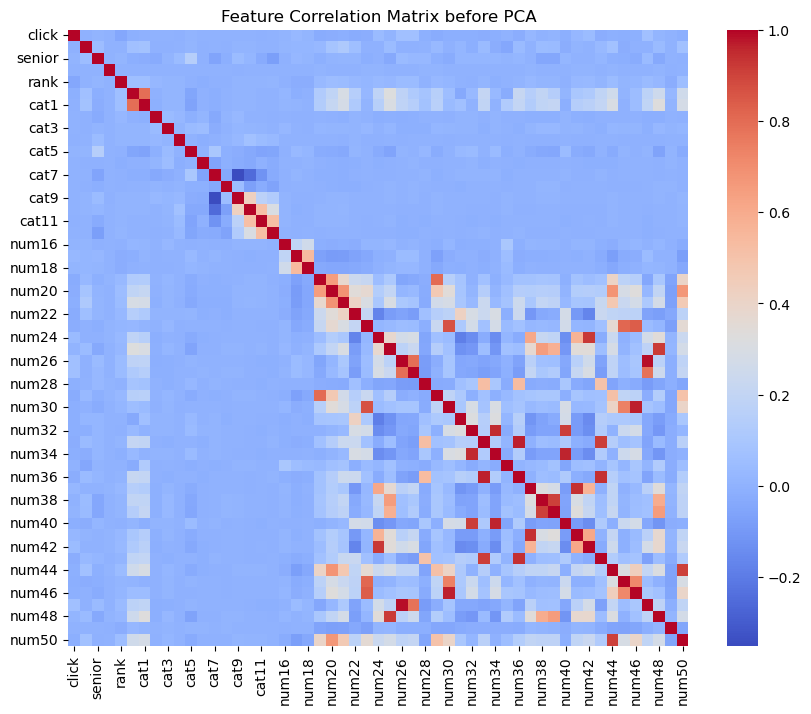

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix before PCA")
plt.show()

In [ ]:
utriangular = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in utriangular.columns if any(utriangular[column] > 0.9)]
num_features = [f for f in num_features if f not in to_drop]

In [ ]:
to_drop

['num34',
 'num36',
 'num39',
 'num40',
 'num41',
 'num42',
 'num43',
 'num46',
 'num47',
 'num48',
 'num50']

<font color='#001affff'>the columns ['num34', 'num36', 'num39', 'num40', 'num41', 'num42', 'num43', 'num46', 'num47', 'num48', 'num50'] will be dropped

In [27]:
raw_df_nosim = raw_df.drop(columns=to_drop)
print(raw_df_nosim.shape)

(1072226, 42)


In [37]:
raw_df_nosim.columns

Index(['click', 'gender', 'senior', 'displayrandom', 'rank', 'cat0', 'cat1',
       'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
       'cat11', 'cat12', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21',
       'num22', 'num23', 'num24', 'num25', 'num26', 'num27', 'num28', 'num29',
       'num30', 'num31', 'num32', 'num33', 'num35', 'num37', 'num38', 'num44',
       'num45', 'num49'],
      dtype='object')

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(raw_df_nosim.drop(columns=['click']), raw_df_nosim['click'], test_size=0.2, random_state=42, stratify=raw_df_nosim['click'])

In [43]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from scipy.sparse import hstack


target = 'click'

# ---- Divide categorical columns by cardinality ----
low_card_cols = [col for col in cat_features if raw_df_nosim[col].nunique() < 150]
mid_card_cols = [col for col in cat_features if 150 <= raw_df_nosim[col].nunique() <= 1000]
high_card_cols = [col for col in cat_features if raw_df_nosim[col].nunique() > 1000]


# ---- Target Encoder for medium cardinality ----
target_enc = TargetEncoder(cols=mid_card_cols)
train_target_encoded = target_enc.fit_transform(X_train[mid_card_cols], y_train)
test_target_encoded = target_enc.transform(X_test[mid_card_cols])

# ---- One-Hot Encoder for low cardinality ----
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
train_ohe = ohe.fit_transform(X_train[low_card_cols])
test_ohe = ohe.transform(X_test[low_card_cols])

# ---- Hashing for high cardinality ----
hasher = FeatureHasher(n_features=128, input_type='string')
train_hash = hasher.transform(X_train[high_card_cols].astype(str).to_dict(orient='records'))
test_hash = hasher.transform(X_test[high_card_cols].astype(str).to_dict(orient='records'))



##### Feature scaling

In [44]:
from scipy import sparse
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

# Scaling numeric features BEFORE combining
scaler = StandardScaler()
scaled_train_numeric = scaler.fit_transform(X_train[num_features].values)
scaled_test_numeric = scaler.transform(X_test[num_features].values)

X_train = hstack([
    sparse.csr_matrix(X_train[num_features].values),  # numeric features
    train_target_encoded,                               # target-encoded features
    train_ohe,                                         # low-cardinality OHE features
    train_hash,                                        # high-cardinality hashed features
    sparse.csr_matrix(X_train[known_features].values)    # the 4 binary features
])

X_test = hstack([
    sparse.csr_matrix(X_test[num_features].values),
    test_target_encoded,
    test_ohe,
    test_hash,
    sparse.csr_matrix(X_test[known_features].values)
])



print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (857780, 395)
Test shape: (214446, 395)


## Applying SMOTE to upsample minority class(click = 1)

In [45]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [47]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(
    sampling_strategy='minority',   # determines how much to oversample
    random_state=42,            # for reproducibility
    k_neighbors=5        
)

# Apply SMOTE only to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())
print("Resampled X shape:", X_train_res.shape)


Before SMOTE: click
0    851789
1      5991
Name: count, dtype: int64
After SMOTE: click
0    851789
1    851789
Name: count, dtype: int64
Resampled X shape: (1703578, 395)


## Dimensionality reduction

In [49]:
from sklearn.decomposition import TruncatedSVD

# Choose number of components (e.g., reduce to 100 features)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit on training data and transform both train and test
X_train_reduced = svd.fit_transform(X_train_res)
X_test_reduced = svd.transform(X_test)

print("Original shape:", X_train_res.shape)
print("Reduced shape:", X_train_reduced.shape)


Original shape: (1703578, 395)
Reduced shape: (1703578, 100)


In [50]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Total variance retained:", explained_variance)


Total variance retained: 0.9925389277444838
